In [2]:
!python -V

Python 3.9.0


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment-2")

<Experiment: artifact_location='file:///C:/Users/Neko/OneDrive/Desktop/learning/Homework/mlops_zoomcamp/experiment-tracking/mlruns/3', creation_time=1685391181651, experiment_id='3', last_update_time=1685391181651, lifecycle_stage='active', name='nyc-taxi-experiment-2', tags={}>

In [8]:
df = pd.read_parquet('../../data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.827368941909368

C:\Users\Neko\AppData\Local\Temp\ipykernel_3008\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\Neko\AppData\Local\Temp\ipykernel_3008\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


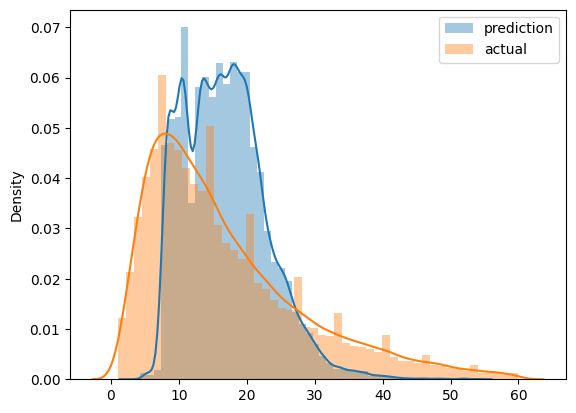

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('../../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../../data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715210678492

In [18]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    mlflow.set_tag("developer", "rex")
    
    mlflow.log_param("train-data-path", '../../data/green_tripdata_2021-01.parquet')
    mlflow.log_param("valid-data-path", '../../data/green_tripdata_2021-02.parquet')
    alpha = .01
    lr = Lasso(alpha)
    mlflow.log_param("alpha", alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)

In [21]:
import xgboost as xgb
from hyperopt.pyll import scope
from hyperopt import tpe, hp, STATUS_OK, Trials, fmin

In [25]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [26]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}
    

In [29]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # [.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[15:37:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.26301                          
[1]	validation-rmse:9.45743                           
[2]	validation-rmse:7.79214                           
[3]	validation-rmse:7.09572                           
[4]	validation-rmse:6.79800                           
[5]	validation-rmse:6.66149                           
[6]	validation-rmse:6.59481                           
[7]	validation-rmse:6.55658                           
[8]	validation-rmse:6.53498                           
[9]	validation-rmse:6.52381                           
[10]	validation-rmse:6.51325                          
[11]	validation-rmse:6.50618                          
[12]	validation-rmse:6.49899                          
[13]	validation-rmse:6.49583                          

In [34]:
mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models/lin_reg.bin")

In [36]:
mlflow.end_run()

In [39]:
with mlflow.start_run():
    best_params = {
        'max_depth': 44,
        'learning_rate': 0.0626397047113715,
        'reg_alpha': 0.019300603770570777,
        'reg_lambda': 0.17744329324529823,
        'min_child_weight': 1.6813251795298942,
        'objective': 'reg:linear',
        'seed': 42,
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

[20:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:20.06952
[1]	validation-rmse:19.02401
[2]	validation-rmse:18.05074
[3]	validation-rmse:17.14572
[4]	validation-rmse:16.30359
[5]	validation-rmse:15.52186
[6]	validation-rmse:14.79802
[7]	validation-rmse:14.12556
[8]	validation-rmse:13.50343
[9]	validation-rmse:12.92866
[10]	validation-rmse:12.39660
[11]	validation-rmse:11.90589
[12]	validation-rmse:11.45386
[13]	validation-rmse:11.03678
[14]	validation-rmse:10.65246
[15]	validation-rmse:10.29905
[16]	validation-rmse:9.97662
[17]	validation-rmse:9.67928
[18]	validation-rmse:9.40627
[19]	validation-rmse:9.15493
[20]	validation-rmse:8.92573
[21]	validation-rmse:8.71782
[22]	validation-rmse:8.52618
[23]	validation-rmse:8.35031
[24]	validation-rmse:8.19006
[25]	validation-rmse:8.04464
[26]	vali

In [40]:
logged_model = 'runs:/33b9a6b4fd934de9b83daeb7d33d768f/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

2023/05/30 20:35:59 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.3.2, required: mlflow==2.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


[20:35:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [41]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 33b9a6b4fd934de9b83daeb7d33d768f

In [42]:
xgboost_model = mlflow.xgboost.load_model('runs:/33b9a6b4fd934de9b83daeb7d33d768f/models_mlflow')

[20:37:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
xgboost_model

In [45]:
y_pred = xgboost_model.predict(valid)

In [46]:
y_pred[:10]

array([14.782535 ,  6.9767895, 15.22963  , 24.265408 ,  9.173774 ,
       17.197939 , 11.240094 ,  8.484424 ,  9.043879 , 20.884155 ],
      dtype=float32)